## **Robustness of the network to positive or negative words removal**

In [ ]:
#import all the necessary packages
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pickle
import numpy as np
import scipy.sparse as sps
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def evaluateTotaleSentiment(word):
    """
    Function use to filter the words. Return the positive and negative score of a word

    input: word

    output: positive and negative score
    """

    tmp = list(swn.senti_synsets(word))

    positive_score = 0
    negative_score = 0

    for evaluation in tmp:
        positive_score = positive_score + evaluation.pos_score()
        negative_score = negative_score + evaluation.neg_score()

    return positive_score, negative_score

In [ ]:
#load the dataset
in_dir = "drive/MyDrive/lab2/"
in_file = "reddit_posts_tot"
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Pwd = Mwd/Mwd.sum(axis=0).flatten()/Mwd.shape[1]
pdoc = Pwd.sum(axis=0).flatten()
Pww = sps.csr_matrix((Pwd/pdoc))*sps.csr_matrix((Pwd.T))

In [ ]:
%run "drive/MyDrive/lab2/communities_mod.ipynb"


bertopic 1.11
softlouvain v1.10
5
removing:   
(2082, 3848)


In [ ]:
#drop duplicate words and remmove POS tagging
words=[word.split()[0] for word in words]
df=pd.DataFrame(words, columns=["word"]).drop_duplicates()
words=list(df['word'])

In [ ]:
#define the sentiment for each word
emotions={}
for i in range(len(words)):

    emotions[words[i]] = evaluateTotaleSentiment(words[i])

In [ ]:
#find completely neutral words (both positive and negative score equal to 0)
indices=[]
words2=[]
i=0
for w in words:
  if((emotions[w][0]==0)&(emotions[w][1]==0)):
    indices.append(i)
    emotions.pop(w)
  else:
    words2.append(w)
  i+=1

In [ ]:
#remove neutral words
print(Pww.shape)
Pww_filtered = np.delete(Pww.toarray(), indices, axis=0)  # Rimuovere le righe
Pww_filtered = np.delete(Pww_filtered, indices, axis=1)  # Rimuovere le colonne
print(Pww_filtered.shape)

(2082, 2082)
(1418, 1418)


In [ ]:
#sort words wrt the sentiment
sorted_words={}
sorted_indices={}
for target_emotion in ["positive", "negative"]:
  i=1
  if(target_emotion=="positive"):
    i=0
  sorted_words[target_emotion] = sorted(emotions.keys(), key=lambda word: emotions[word][i], reverse=True)
  indexed_list = [(value, index) for index, value in enumerate(words2)]
  sorted_indices[target_emotion] = [index for value, index in sorted(indexed_list, key=lambda x: sorted_words[target_emotion].index(x[0]))]

In [ ]:
def giant_component_size(graph):
  '''
  input : networkx graph

  output : giant component size
  '''
  return len(max(nx.connected_components(graph), key=len))

In [ ]:
#the network is super connected, select only strongest links
Pww_masked=Pww_filtered*(Pww_filtered>0.00003)

0.000847457627118644
0.000847457627118644


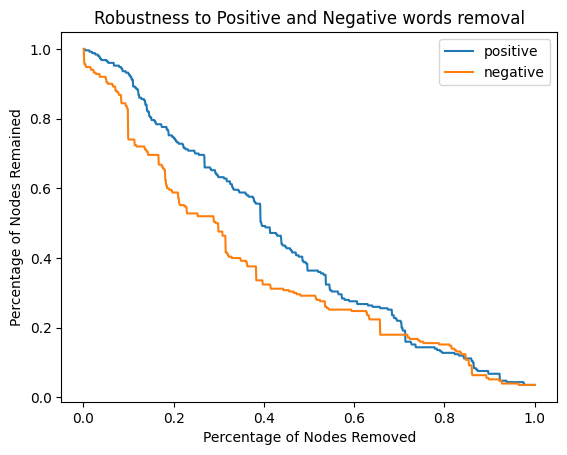

In [ ]:
#compute robustness
percent_nodes_removed={}
percent_nodes_remaining={}

for target_emotion in ["positive", "negative"]:
  G=nx.from_numpy_array(Pww_masked)
  initial_gc= giant_component_size(G)
  gc_sizes=[]
  perc=[]
  i=0
  for node in sorted_indices[target_emotion]:
      # remove the node from the graph
      G.remove_node(node)
      i+=1
      # compute dimension of the new giant component
      if(len(list(nx.connected_components(G)))!=0):
        current_gc_size = giant_component_size(G)
      else:
        break
      if (nx.is_connected(G) | ((i/len(words))>1)):
        continue
      else:
        gc_sizes.append(current_gc_size)
        perc.append(i/len(words2))

  percent_nodes_removed[target_emotion]=perc
  percent_nodes_remaining[target_emotion] = [size / initial_gc for size in gc_sizes]
  plt.plot(percent_nodes_removed[target_emotion], percent_nodes_remaining[target_emotion], label=target_emotion)
  print(min(percent_nodes_removed[target_emotion]))

plt.xlabel('Percentage of Nodes Removed')
plt.ylabel('Percentage of Nodes Remained')
plt.title('Robustness to Positive and Negative words removal')
plt.legend()
plt.show()

## **Robustness for each community**
Define the positivity or negativity of the most relevant communities

In [ ]:
 #reload the dataset
in_dir = "drive/MyDrive/lab2/"
in_file = "reddit_posts_tot"
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

#load the community assignment
in_dir = "drive/MyDrive/dataset/"
C_l=pickle.load(open(in_dir+"C_l_na_post.p", "rb"))
d_C_l = C_l.toarray()


5
removing:   


In [ ]:
in_dir = "drive/MyDrive/lab2/"
in_file = "reddit_posts_tot"
# load text
df2 = pd.read_excel(in_dir+in_file+"_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# remove those documents that do not appear in Pcc
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

In [ ]:
def list_words(string):
  '''
  Function to format the text_deep_clean_pos in the proper way

  input : string

  output : formatted string
  '''
  string=string.replace("'", "").replace("[", "").replace("]", "")
  mylist=string.split(',')
  return mylist

#from string to list of words
df2['text_deep_clean_pos']=df2['text_deep_clean_pos']. apply(list_words)

(1015,)
(1940, 2833)
606
(455,)
(2043, 3393)
651
(391,)
(2051, 3457)
652
(277,)
(2050, 3571)
644


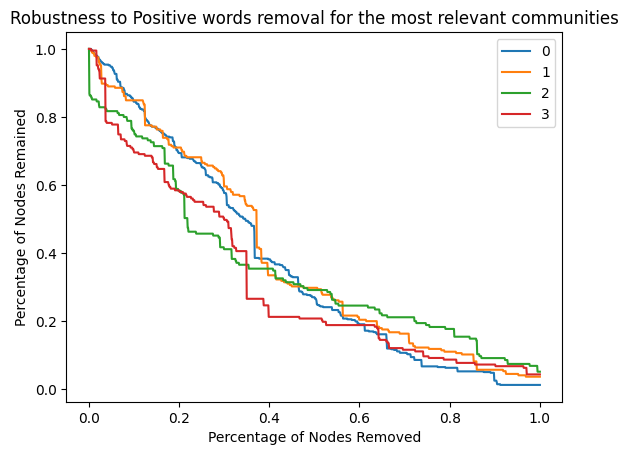

In [ ]:
wordsCom={}
num=[0,1,2,3,20]
for i in range(4):
  mask_column = d_C_l[:, i].astype(int)
  indices=np.where(mask_column)[0]

  #Mwd of the community
  print(indices.shape)
  Mwd_c=np.delete(Mwd, indices, axis=1)
  not_null = np.any(Mwd_c != 0, axis=1)
  Mwd_c = Mwd_c[not_null]

  print(Mwd_c.shape)
  Pwd = Mwd_c/Mwd_c.sum(axis=0).flatten()/Mwd_c.shape[1]
  pdoc = Pwd.sum(axis=0).flatten()
  #Pww of the community
  Pww_c = sps.csr_matrix((Pwd/pdoc))*sps.csr_matrix((Pwd.T))

  #documents in the community
  doc=df2.iloc[np.where(mask_column)[0],:]

  #words in the community
  doc_list=doc['text_deep_clean'].tolist()
  wordsCom[i]=words[not_null]
  words1=[word.split()[0] for word in wordsCom[i]]

  df=pd.DataFrame(words1, columns=["word"]).drop_duplicates()
  words1=list(df['word'])

  #compute positive and negative values for each word in the community
  emotions={}
  for j in range(len(words1)):

    emotions[words1[j]] = evaluateTotaleSentiment(words1[j])

  #find neutral words
  indices=[]
  words2=[]
  j=0
  for w in words1:
    if((emotions[w][0]==0)&(emotions[w][1]==0)):
      indices.append(j)
      emotions.pop(w)
    else:
      words2.append(w)
    j+=1
  print(len(indices))
  #remove neutral words
  Pww_filtered = np.delete(Pww_c.toarray(), indices, axis=0)  # remove rows
  Pww_filtered = np.delete(Pww_filtered, indices, axis=1)  # remove columns

  #define most negative words
  emotions = {key: value[1] for key, value in emotions.items()}

  sorted_words = sorted(emotions.keys(), key=lambda word: emotions[word], reverse=True)
  indexed_list = [(value, index) for index, value in enumerate(words2)]
  sorted_indices = [index for value, index in sorted(indexed_list, key=lambda x: sorted_words.index(x[0]))]

  #consider only strongest links
  Pww_masked=Pww_filtered*(Pww_filtered>0.000037)

  #compute robustness
  G=nx.from_numpy_array(Pww_masked)
  initial_gc= giant_component_size(G)
  gc_sizes=[]
  perc=[]
  j=0
  for node in sorted_indices:
      # remove the node from the graph
      G.remove_node(node)
      j+=1
      # compute dimension of the new giant component
      if(len(list(nx.connected_components(G)))!=0):
        current_gc_size = giant_component_size(G)
      else:
        break
      if (nx.is_connected(G) | ((i/len(words))>1)):
        continue
      else:
        gc_sizes.append(current_gc_size)
        perc.append(j/len(words2))

  percent_nodes_removed=perc
  percent_nodes_remaining = [size / initial_gc for size in gc_sizes]
  plt.plot(percent_nodes_removed, percent_nodes_remaining, label=i)
plt.xlabel('Percentage of Nodes Removed')
plt.ylabel('Percentage of Nodes Remained')
plt.title('Robustness to Positive words removal for the most relevant communities')
plt.legend()
plt.show()

##**Degree Robustness**
Robustness of the network to hub removal

In [ ]:
 #reload the dataset
in_dir = "drive/MyDrive/lab2/"
in_file = "reddit_posts_tot"
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Pwd = Mwd/Mwd.sum(axis=0).flatten()/Mwd.shape[1]
pdoc = Pwd.sum(axis=0).flatten()
Pww = sps.csr_matrix((Pwd/pdoc))*sps.csr_matrix((Pwd.T))
G=nx.from_numpy_array(Pww)


In [ ]:
#compute pagerang and sort nodes wrt it
pr = nx.pagerank(G)
sorted_words_pr = sorted(pr.keys(), key=lambda word: pr[word], reverse=True)

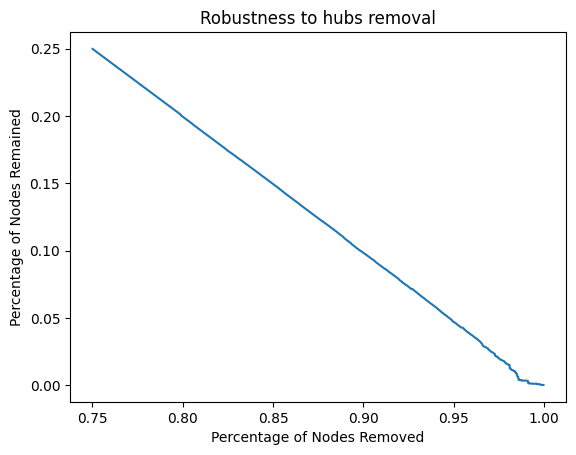

In [ ]:
#compute robustness
initial_gc= giant_component_size(G)
gc_sizes=[]
perc=[]
i=0
for node in sorted_words_pr:
    # remove the node from the graph
    G.remove_node(node)
    i+=1
    # compute dimension of the new giant component
    if(len(list(nx.connected_components(G)))!=0):
      prec=current_gc_size
      current_gc_size = giant_component_size(G)
    else:
      break
    if (nx.is_connected(G) | ((i/len(words))<0.75)):
      continue
    else:
      gc_sizes.append(current_gc_size)
      perc.append(i/len(words))


percent_nodes_remaining = [size / initial_gc for size in gc_sizes]
plt.plot(perc, percent_nodes_remaining)

plt.xlabel('Percentage of Nodes Removed')
plt.ylabel('Percentage of Nodes Remained')
plt.title('Robustness to hubs removal')

plt.show()

In [ ]:
gc_sizes

In [ ]:
len(words)

1844

In [ ]:
documents

array(['10xv170', '102c551', '11wkbgt', ..., '18cbzsb', '16edk6s',
       '159b2y2'], dtype='<U7')